In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils import data
from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt
import sys
import utils
# sys.path.append('/kaggle/input')
# from myutils import utils

In [2]:
class Residual (nn.Module):
    def __init__(self, input_channels, num_channels, strides=1, use_1x1conv=False):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv :
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    def forward (self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [3]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [4]:
def resnet_block(input_channels, num_channels, num_residuals, first_block = False):
    blk = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            #第一个长宽减半
            blk.append(Residual(input_channels, num_channels,strides=2, use_1x1conv=True))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk        

In [5]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [6]:
net = nn.Sequential(b1, b2, b3, b4, b5,
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(), nn.Linear(512, 10)
)

In [7]:
X = torch.rand(size=(1,1,224,224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'out shape:\t',X.shape)

Sequential out shape:	 torch.Size([1, 64, 56, 56])
Sequential out shape:	 torch.Size([1, 64, 56, 56])
Sequential out shape:	 torch.Size([1, 128, 28, 28])
Sequential out shape:	 torch.Size([1, 256, 14, 14])
Sequential out shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d out shape:	 torch.Size([1, 512, 1, 1])
Flatten out shape:	 torch.Size([1, 512])
Linear out shape:	 torch.Size([1, 10])


In [8]:
def train_ch6(net , train_iter, test_iter, num_epochs, lr, device):
    def init_weight(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)
    net.to(device)
    print('training on', device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    num_batches = len(train_iter)
    animator = utils.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in tqdm(range(num_epochs)):
        net.train()
        metric = utils.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l* X.shape[0], utils.accuracy(y_hat, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = utils.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')    

100%|██████████| 10/10 [1:04:38<00:00, 387.81s/it]

loss 0.009, train acc 0.998, test acc 0.894


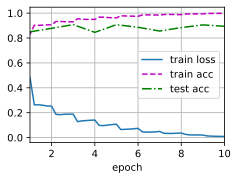

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_data, test_data = utils.load_data_fashion_mnist(batch_size, resize=96)
train_ch6(net, train_data, test_data, num_epochs, lr, utils.try_gpu())

In [1]:
!nvidia-smi

Wed Mar 30 18:11:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P400        WDDM  | 00000000:01:00.0 Off |                  N/A |
| 34%   45C    P8    N/A /  N/A |      0MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
a = torch.tensor()